In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import math
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import scipy.io as sio
plt.rcParams['figure.figsize'] = 8,8

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

import scipy

In [2]:
df_orig = pd.read_csv('facelabelsandstats.csv')
df_orig.head()
df_orig['label'].unique()

array(['baby', 'child', 'middle_aged', 'senior', 'youth'], dtype=object)

In [3]:
df = df_orig.drop(['face_id'], axis = 1)
df.head()

,label,crop_w,crop_h,crop_x0,crop_y0,yaw,pitch,roll,left_eye_left_x,left_eye_left_y,left_eye_right_x,left_eye_right_y,right_eye_left_x,right_eye_left_y,right_eye_right_x,right_eye_right_y,mouth_left_x,mouth_left_y,mouth_right_x,mouth_right_y
0,baby,318,324,0,0,3,2,8,104,132,140,139,190,147,226,147,124,222,184,229
1,baby,333,487,0,13,-7,4,3,29,295,73,299,137,300,190,295,65,426,148,428
2,baby,180,252,16,125,-2,10,7,62,107,78,109,103,111,121,110,72,147,106,151
3,baby,333,500,0,0,-8,8,3,66,246,112,249,181,250,234,246,104,374,188,376
4,baby,204,284,188,48,-6,-7,8,65,117,87,121,123,126,151,125,79,179,127,187


In [4]:
df.columns = ['label',
           'crop_w',
           'crop_h',
           'crop_x0',
           'crop_y0',
           'yaw',
           'pitch',
           'roll',
           'left_eye_left_x',
           'left_eye_left_y',
           'left_eye_right_x',
           'left_eye_right_y',
           'right_eye_left_x',
           'right_eye_left_y',
           'right_eye_right_x',
           'right_eye_right_y',
           'mouth_left_x',
           'mouth_left_y',
           'mouth_right_x',
           'mouth_right_y',]

label_names = ['baby',
              'child',
              'youth',
              'middle-aged',
              'senior']

In [5]:
def convert_label(label):
    if label == 'baby':
        return 0
    elif label == 'child':
        return 1
    elif label == 'youth':
        return 2
    elif label == 'middle_aged':
        return 3
    else:
        return 4

In [6]:
df['label'] = df['label'].apply(convert_label)
df.head()

,label,crop_w,crop_h,crop_x0,crop_y0,yaw,pitch,roll,left_eye_left_x,left_eye_left_y,left_eye_right_x,left_eye_right_y,right_eye_left_x,right_eye_left_y,right_eye_right_x,right_eye_right_y,mouth_left_x,mouth_left_y,mouth_right_x,mouth_right_y
0,0,318,324,0,0,3,2,8,104,132,140,139,190,147,226,147,124,222,184,229
1,0,333,487,0,13,-7,4,3,29,295,73,299,137,300,190,295,65,426,148,428
2,0,180,252,16,125,-2,10,7,62,107,78,109,103,111,121,110,72,147,106,151
3,0,333,500,0,0,-8,8,3,66,246,112,249,181,250,234,246,104,374,188,376
4,0,204,284,188,48,-6,-7,8,65,117,87,121,123,126,151,125,79,179,127,187


In [7]:
df_cols = df.columns.tolist()
df_cols = df_cols[1:] + df_cols[:1]
df = df[df_cols]

In [8]:
df.head()

,crop_w,crop_h,crop_x0,crop_y0,yaw,pitch,roll,left_eye_left_x,left_eye_left_y,left_eye_right_x,left_eye_right_y,right_eye_left_x,right_eye_left_y,right_eye_right_x,right_eye_right_y,mouth_left_x,mouth_left_y,mouth_right_x,mouth_right_y,label
0,318,324,0,0,3,2,8,104,132,140,139,190,147,226,147,124,222,184,229,0
1,333,487,0,13,-7,4,3,29,295,73,299,137,300,190,295,65,426,148,428,0
2,180,252,16,125,-2,10,7,62,107,78,109,103,111,121,110,72,147,106,151,0
3,333,500,0,0,-8,8,3,66,246,112,249,181,250,234,246,104,374,188,376,0
4,204,284,188,48,-6,-7,8,65,117,87,121,123,126,151,125,79,179,127,187,0


## Defining Functions

In [9]:
def get_scaled(train, test):
    
    scaler = StandardScaler()
    train = train.astype(float)
    test = test.astype(float)
    X_train = scaler.fit_transform(train)
    X_test = scaler.transform(test)
    
    return X_train, X_test

In [10]:
def get_clf(clf, params, cv):
    
    grid = GridSearchCV(clf, params, cv = cv, return_train_score = True, iid = True)
    
    return grid

In [11]:
def get_accuracy(clf, X, Y):
    
    train_max = max(clf.cv_results_['mean_train_score'])
    val_max = max(clf.cv_results_['mean_test_score'])
    
    print(clf.best_params_)
    pred = clf.predict(X)
    acc = (np.sum(pred == Y) / len(Y)).item()
    
    return train_max, val_max, acc, pred

In [12]:
def draw_heatmap_linear(acc, acc_desc, C_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=C_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

In [13]:
def draw_heatmap_RBF(acc, acc_desc, gamma_list, C_list):
    plt.figure(figsize = (5,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = '$\gamma$', ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$ and $\gamma$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

## Instantiate Classifiers

In [14]:
#Linear SVM

C_list = [10e-4, 10e-3, 10e-2, 1, 10e1, 10e2]
params = [{'C': C_list}]

svm_clf = get_clf(svm.LinearSVC(dual = False), params, 10)

In [15]:
#RBF SVM

C_list2 = [10e-4, 10e-3, 10e-2, 1, 10e1, 10e2]
G_list = [1e3, 1e2, 1, 1e-2, 1e-3, 1e-5]
params = {'gamma': G_list, 'C': C_list}

rbf_clf = get_clf(svm.SVC(kernel = 'rbf'), params, 10)

In [28]:
#Logistic Regression
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparams = dict(C = C, penalty = penalty)

lr_clf = GridSearchCV(LogisticRegression(max_iter = 300), hyperparams, cv = 10, n_jobs = -1, return_train_score = True, iid = True)

## Experiment

#### Easy Classification (Baby vs. Senior)

In [17]:
baby = df[df.label.isin([0])]
babyX = baby.values[:, :-1]
babyY = baby.values[:, -1]
senior = df[df.label.isin([4])]
seniorX = senior.values[:, :-1]
seniorY = senior.values[:, -1]

baby_train, baby_test, blabel_train, blabel_test = train_test_split(babyX, babyY, test_size = 0.2)
senior_train, senior_test, slabel_train, slabel_test = train_test_split(seniorX, seniorY, test_size = 0.2)

X_train = np.concatenate((baby_train, senior_train))
X_test = np.concatenate((baby_test, senior_test))
Y_train = np.concatenate((blabel_train, slabel_train))
Y_test = np.concatenate((blabel_test, slabel_test))

X_train_scaled, X_test_scaled = get_scaled(X_train, X_test)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(320, 19) (80, 19) (320,) (80,)


{'C': 100.0}
Training accuracy:  0.8555555555555555 
Validation accuracy:  0.825 
Testing accuracy:  0.7875


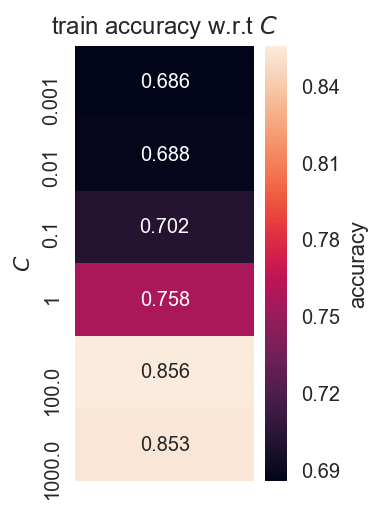

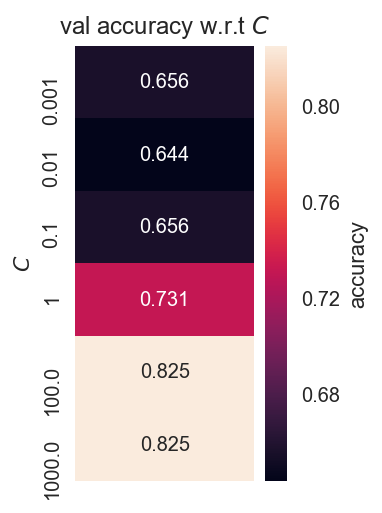

In [46]:
#Linear SVM

svm_BS = svm_clf.fit(X_train_scaled, Y_train)
train_acc_max, val_acc_max, test_acc, y_pred = get_accuracy(svm_BS, X_test_scaled, Y_test)
print('Training accuracy: ', train_acc_max, 
      '\nValidation accuracy: ', val_acc_max, 
      '\nTesting accuracy: ', test_acc)

train_acc = svm_BS.cv_results_['mean_train_score'].reshape(6, 1)
val_acc = svm_BS.cv_results_['mean_test_score'].reshape(6, 1)

draw_heatmap_linear(train_acc, 'train accuracy', C_list)
draw_heatmap_linear(val_acc, 'val accuracy', C_list)

{'C': 1000.0, 'gamma': 0.01}
Training accuracy:  1.0 
Validation accuracy:  0.725 
Testing accuracy:  0.7125


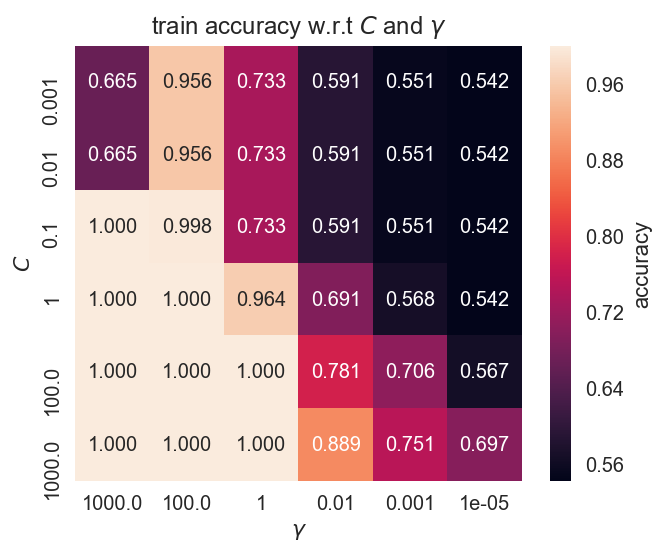

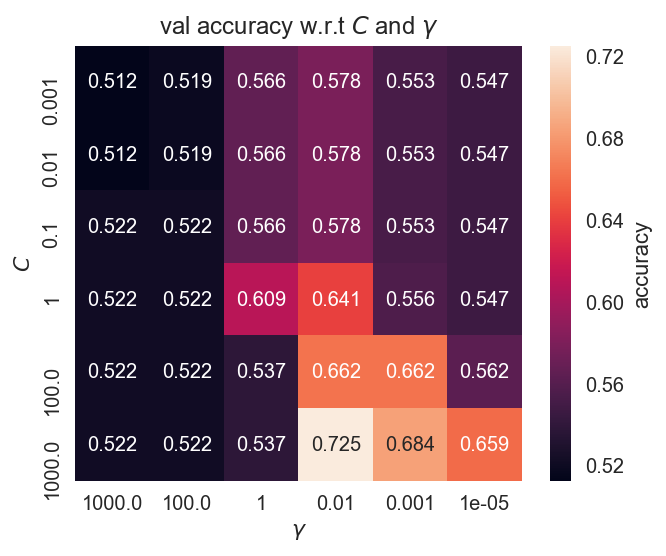

In [47]:
#SVM RBF

rbf_BS = rbf_clf.fit(X_train_scaled, Y_train)
train_acc_max2, val_acc_max2, test_acc2, y_pred2 = get_accuracy(rbf_BS, X_test_scaled, Y_test)
print('Training accuracy: ', train_acc_max2, 
      '\nValidation accuracy: ', val_acc_max2, 
      '\nTesting accuracy: ', test_acc2)

train_acc2 = rbf_BS.cv_results_['mean_train_score'].reshape(6, 6)
val_acc2 = rbf_BS.cv_results_['mean_test_score'].reshape(6, 6)

draw_heatmap_RBF(train_acc2, 'train accuracy', G_list, C_list)
draw_heatmap_RBF(val_acc2, 'val accuracy', G_list , C_list)

In [48]:
#Logistic Regression

lr_BS = lr_clf.fit(X_train_scaled, Y_train)
train_acc_lr, val_acc_lr, test_acc_lr, y_pred_lr = get_accuracy(lr_BS, X_test_scaled, Y_test)
print('Training accuracy: ', train_acc_lr,
     '\nValidation accuracy: ', val_acc_lr,
     '\nTesting accuracy: ', test_acc_lr)

train_acc_lr = lr_BS.cv_results_['mean_train_score']
val_acc_lr = lr_BS.cv_results_['mean_test_score']

print(classification_report(Y_test, y_pred_lr, target_names = ['baby', 'senior']))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 59.94842503189409, 'penalty': 'l1'}
Training accuracy:  0.8670138888888888 
Validation accuracy:  0.8375 
Testing accuracy:  0.775
              precision    recall  f1-score   support

        baby       0.78      0.78      0.78        40
      senior       0.78      0.78      0.78        40

   micro avg       0.78      0.78      0.78        80
   macro avg       0.78      0.78      0.78        80
weighted avg       0.78      0.78      0.78        80



In [33]:
print(lr_BC.best_estimator_.coef_)
print(lr_BC.best_estimator_.intercept_)

[[-4.01054234e+00  9.83862912e+00  7.12034181e-01 -3.32698747e-01
   7.52443661e-02 -6.23966128e-01 -4.46951556e-01  3.06242683e+01
   5.13925112e+01  1.41460228e+01 -1.26683512e+01  8.64503195e+00
  -1.09777440e+02 -3.51271913e+01  4.64793213e+01 -4.23724916e+01
   5.89785018e+00  9.84766198e+00  2.49243827e+01]]
[-0.69169791]


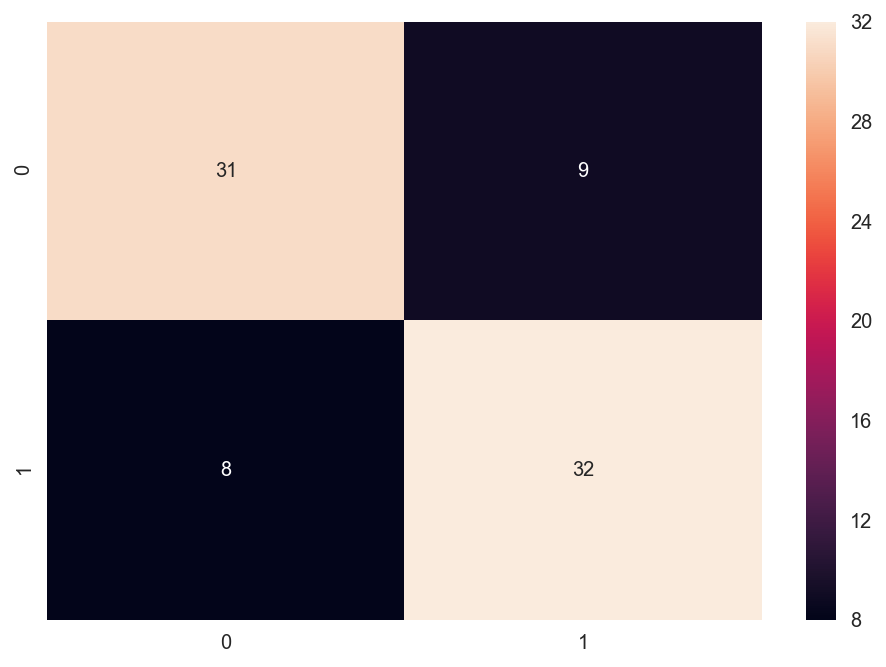

In [42]:
linear = confusion_matrix(Y_test, y_pred)
sns.heatmap(linear, annot = True)

In [43]:
print(classification_report(Y_test, y_pred, target_names = ['baby', 'senior']))

              precision    recall  f1-score   support

        baby       0.79      0.78      0.78        40
      senior       0.78      0.80      0.79        40

   micro avg       0.79      0.79      0.79        80
   macro avg       0.79      0.79      0.79        80
weighted avg       0.79      0.79      0.79        80



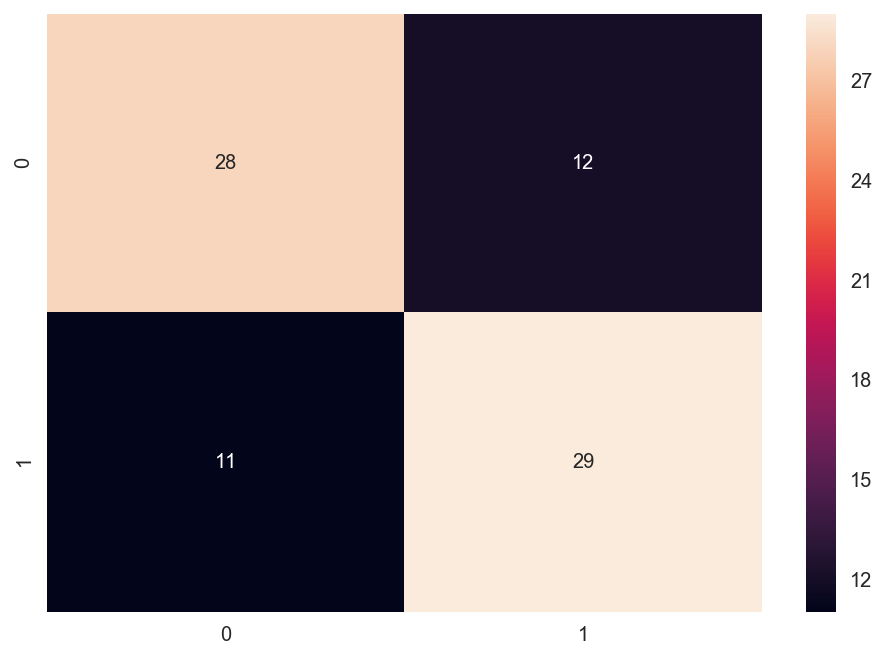

In [44]:
rbf = confusion_matrix(Y_test, y_pred2)
sns.heatmap(rbf, annot = True)

In [45]:
print(classification_report(Y_test, y_pred2, target_names = ['baby', 'senior']))

              precision    recall  f1-score   support

        baby       0.72      0.70      0.71        40
      senior       0.71      0.72      0.72        40

   micro avg       0.71      0.71      0.71        80
   macro avg       0.71      0.71      0.71        80
weighted avg       0.71      0.71      0.71        80



#### Hard Classification (Baby vs. Child)

In [53]:
baby = df[df.label.isin([0])]
babyX = baby.values[:, :-1]
babyY = baby.values[:, -1]
c2 = df[df.label.isin([1])]
c2X = c2.values[:, :-1]
c2Y = c2.values[:, -1]

baby_train, baby_test, blabel_train, blabel_test = train_test_split(babyX, babyY, test_size = 0.2)
c2_train, c2_test, c2label_train, c2label_test = train_test_split(c2X, c2Y, test_size = 0.2)

X_train2 = np.concatenate((baby_train, c2_train))
X_test2 = np.concatenate((baby_test, c2_test))
Y_train2 = np.concatenate((blabel_train, c2label_train))
Y_test2 = np.concatenate((blabel_test, c2label_test))

X_train_scaled2, X_test_scaled2 = get_scaled(X_train2, X_test2)

print(X_train2.shape, X_test2.shape, Y_train2.shape, Y_test2.shape)

(320, 19) (80, 19) (320,) (80,)


{'C': 1}
Training accuracy:  0.7399305555555555 
Validation accuracy:  0.6875 
Testing accuracy:  0.7125


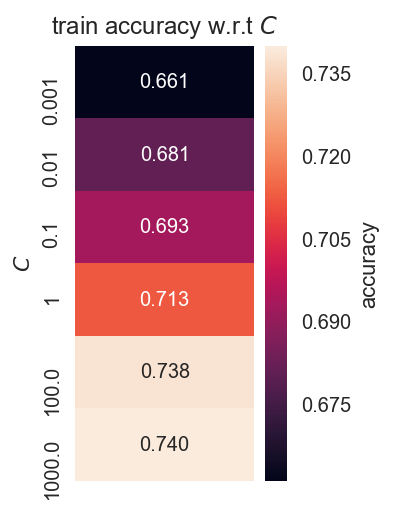

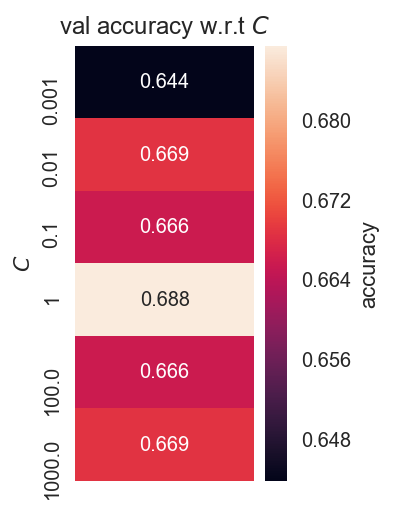

In [54]:
#Linear SVM

svm_BC = svm_clf.fit(X_train_scaled2, Y_train2)
train_acc_max3, val_acc_max3, test_acc3, y_pred3 = get_accuracy(svm_BC, X_test_scaled2, Y_test2)
print('Training accuracy: ', train_acc_max3, 
      '\nValidation accuracy: ', val_acc_max3, 
      '\nTesting accuracy: ', test_acc3)

train_acc3 = svm_BC.cv_results_['mean_train_score'].reshape(6, 1)
val_acc3 = svm_BC.cv_results_['mean_test_score'].reshape(6, 1)

draw_heatmap_linear(train_acc3, 'train accuracy', C_list)
draw_heatmap_linear(val_acc3, 'val accuracy', C_list)

{'C': 1000.0, 'gamma': 0.001}
Training accuracy:  1.0 
Validation accuracy:  0.68125 
Testing accuracy:  0.6875


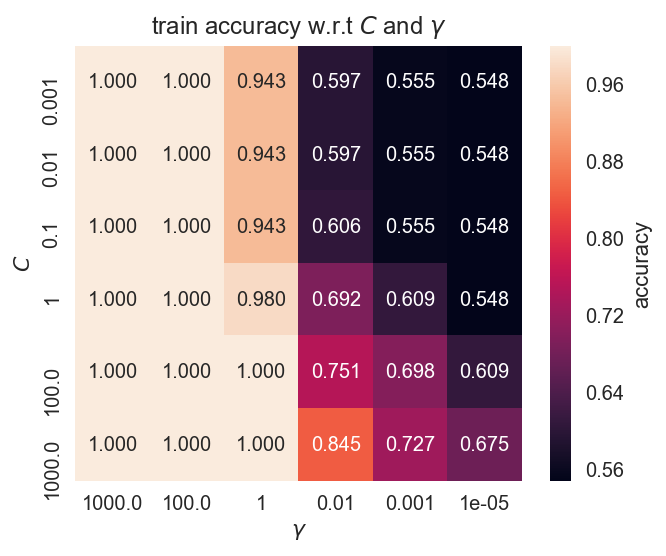

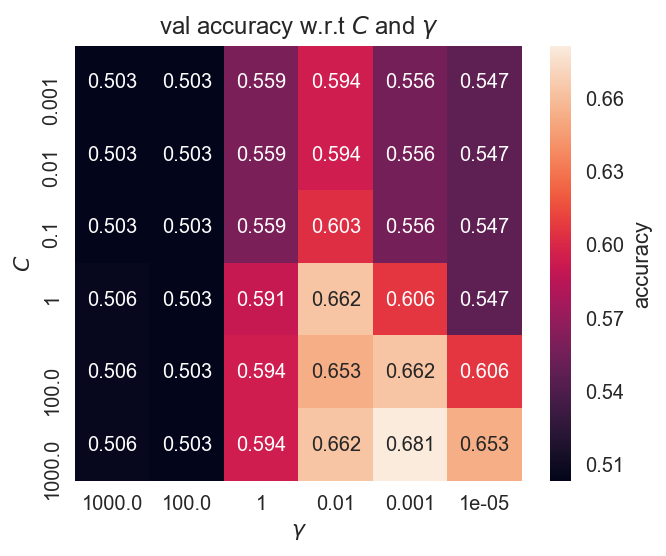

In [55]:
#SVM RBF

rbf_BC = rbf_clf.fit(X_train_scaled2, Y_train2)
train_acc_max4, val_acc_max4, test_acc4, y_pred4 = get_accuracy(rbf_BC, X_test_scaled2, Y_test2)
print('Training accuracy: ', train_acc_max4, 
      '\nValidation accuracy: ', val_acc_max4, 
      '\nTesting accuracy: ', test_acc4)

train_acc4 = rbf_BC.cv_results_['mean_train_score'].reshape(6, 6)
val_acc4 = rbf_BC.cv_results_['mean_test_score'].reshape(6, 6)

draw_heatmap_RBF(train_acc4, 'train accuracy', G_list, C_list)
draw_heatmap_RBF(val_acc4, 'val accuracy', G_list , C_list)

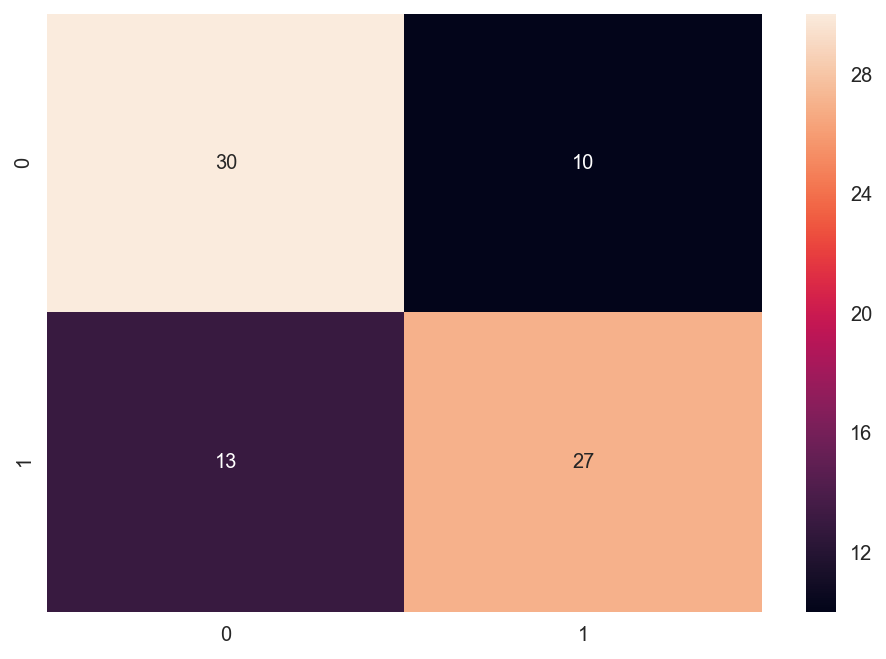

In [56]:
linear = confusion_matrix(Y_test2, y_pred3)
sns.heatmap(linear, annot = True)

In [57]:
print(classification_report(Y_test2, y_pred3, target_names = ['baby', 'child']))

              precision    recall  f1-score   support

        baby       0.70      0.75      0.72        40
       child       0.73      0.68      0.70        40

   micro avg       0.71      0.71      0.71        80
   macro avg       0.71      0.71      0.71        80
weighted avg       0.71      0.71      0.71        80



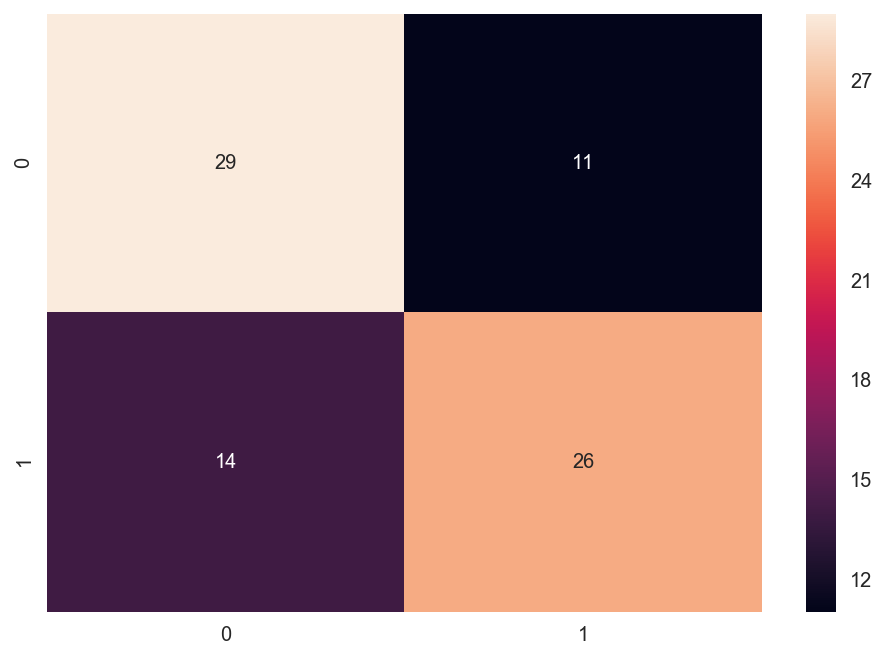

In [58]:
rbf = confusion_matrix(Y_test2, y_pred4)
sns.heatmap(rbf, annot = True)

In [59]:
print(classification_report(Y_test2, y_pred4, target_names = ['baby', 'child']))

              precision    recall  f1-score   support

        baby       0.67      0.72      0.70        40
       child       0.70      0.65      0.68        40

   micro avg       0.69      0.69      0.69        80
   macro avg       0.69      0.69      0.69        80
weighted avg       0.69      0.69      0.69        80

